# Real Estate Transactions Analysis
This notebook analyzes a dataset of real estate transactions. The dataset includes various fields related to real estate sales in the Tamsui District. The key steps in this analysis are:
1. Filtering the dataset to include specific transaction types.
2. Converting transaction dates from ROC calendar to Gregorian calendar.
3. Calculating the age of buildings at the time of transaction.
4. Creating histograms to visualize the volume of transactions over time and the distribution of building ages.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

## Load and Filter the Dataset
The dataset is first loaded, and then filtered to include only transactions of type '房地(土地+建物)' and '房地(土地+建物)+車位'.

In [2]:
# Load the dataset
# file_path = '../data/歷年不動產實價登錄資訊-買賣案件-111年-淡水區.csv' # Replace with the actual file path
file_path = '../data/不動產實價登錄資訊-買賣案件-淡水區.csv'
real_estate_data = pd.read_csv(file_path, dtype={'rps14': str})

real_estate_data

# Filter the dataset
filtered_data = real_estate_data[real_estate_data['rps01'].isin(['房地(土地+建物)', '房地(土地+建物)+車位'])]

## Convert ROC Dates to Gregorian Dates
The ROC dates in the 'rps07' (transaction date) and 'rps14' (building completion date) columns are converted to the Gregorian calendar format.

In [3]:
# Function to convert ROC dates to Gregorian dates
def roc_to_gregorian_safe(roc_date):
    try:
        roc_date_str = str(roc_date)
        year_length = 3 if len(roc_date_str) == 7 else 2
        year = int(roc_date_str[:year_length]) + 1911
        month = int(roc_date_str[year_length:year_length+2])
        day = int(roc_date_str[year_length+2:])
        return pd.Timestamp(year, month, day)
    except Exception as e:
        print(f"Error converting {roc_date}: {e}")
        return pd.NaT

# Apply the conversion to the dataset
filtered_data['transaction_date'] = filtered_data['rps07'].apply(roc_to_gregorian_safe)
filtered_data['completion_date'] = filtered_data['rps14'].apply(roc_to_gregorian_safe)
filtered_data['building_age'] = filtered_data.apply(lambda row: (row['transaction_date'] - row['completion_date']).days / 365.25 if row['completion_date'] is not None else None, axis=1)

# Due to the statistic 
filtered_data = filtered_data[filtered_data['transaction_date'] >= pd.Timestamp(2021, 12, 1)]

Error converting nan: invalid literal for int() with base 10: 'na'
Error converting nan: invalid literal for int() with base 10: 'na'
Error converting nan: invalid literal for int() with base 10: 'na'
Error converting nan: invalid literal for int() with base 10: 'na'


/var/folders/qg/t_r78j517zv8dqw51p1cj9100000gn/T/ipykernel_32105/3055025894.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['transaction_date'] = filtered_data['rps07'].apply(roc_to_gregorian_safe)
/var/folders/qg/t_r78j517zv8dqw51p1cj9100000gn/T/ipykernel_32105/3055025894.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['completion_date'] = filtered_data['rps14'].apply(roc_to_gregorian_safe)
/var/folders/qg/t_r78j517zv8dqw51p1cj9100000gn/T/ipykernel_32105/3055025894.py:

In [4]:
print(filtered_data['transaction_date'].dtype)
print(filtered_data['completion_date'].dtype)
print(filtered_data['building_age'].dtype)


datetime64[ns]
datetime64[ns]
float64


### Unit Conversion: Converting from Square Meters to Ping

In this section of the code, we focus on converting the unit of area in the real estate transaction dataset from square meters to the commonly used unit in Taiwan, "ping." This conversion is crucial for in-depth analysis of the Taiwanese real estate market because "ping" is the prevalent area unit in the region.

#### Conversion Factor
First, we set the conversion factor `sqm_to_ping` with a value of 3.305785. This value is used to convert square meters into ping.

#### Area Columns to Convert
Next, we define a series of columns that need conversion. These columns include the total transaction area, parking area, main building area, auxiliary building area, and balcony area. These columns are identified with the codes `rps15`, `rps24`, `rps28`, `rps29`, and `rps30`, respectively.

#### Conversion Process
- We use the `area_conversion` dictionary to map column names from the original dataset to the new naming convention.
- By iterating through the dictionary using a loop, we convert the values of each specified column from square meters to ping.
- Additionally, we convert the price per square meter (`rps22`) into the price per ping.

#### Calculation of Public Facility Proportion
- To analyze the structure of buildings in more depth, we calculate the proportion of public facilities. This is achieved by subtracting the area of all other components from the total area.
- Ensuring that the resulting proportion falls within a reasonable range, typically between 0 and 1.

The purpose of this code segment is to transform key data in the dataset into a format more suitable for analysis in the Taiwanese market, making the analysis results more closely aligned with the actual conditions of the local real estate market.

In [5]:

# Conversion factor from square meters to 坪 (Taiwanese unit)
sqm_to_ping = 3.305785

# Columns in the dataset that represent area in square meters
# area_columns = ['rps03', 'rps15', 'rps24', 'rps28', 'rps29', 'rps30']
# Define a mapping for area conversions
area_conversion = {
    'rps03': 'land_area_ping',
    'rps15': 'total_area_ping',
    'rps24': 'parking_area_ping',
    'rps28': 'main_building_area_ping',
    'rps29': 'auxiliary_building_area_ping',
    'rps30': 'balcony_area_ping'
}

# Convert these columns from square meters to 坪 using the new naming convention
for original_column, new_column in area_conversion.items():
    filtered_data[new_column] = filtered_data[original_column] / sqm_to_ping

# Convert 'rps22' (price per square meter) to price per 坪
filtered_data['price_per_ping'] = filtered_data['rps22'] * sqm_to_ping
filtered_data['price_per_ping_10k'] = filtered_data['price_per_ping'] / 10000

# Calculate the public facility ratio
filtered_data['public_facility_ratio'] = (filtered_data['total_area_ping'] - filtered_data['main_building_area_ping'] - filtered_data['auxiliary_building_area_ping'] - filtered_data['balcony_area_ping'] - filtered_data['parking_area_ping']) / filtered_data['total_area_ping']

# Ensure that the ratio does not go beyond reasonable limits
filtered_data['public_facility_ratio'] = filtered_data['public_facility_ratio'].clip(lower=0, upper=1)

# Display the first few rows of the dataframe with the public facility ratio
display_columns = list(area_conversion.values()) + ['rps22', 'price_per_ping', 'public_facility_ratio']
print(filtered_data[display_columns].head())

   land_area_ping  total_area_ping  parking_area_ping  \
2        2.060025        18.966751            0.00000   
5        2.123550         9.837300            0.00000   
6        3.929475        23.204776            2.63175   
8        1.681900         9.444050            0.00000   
9        8.085825        57.611127           11.04730   

   main_building_area_ping  auxiliary_building_area_ping  balcony_area_ping  \
2                10.599600                       0.00000           1.839200   
5                 5.986475                       0.00000           0.946825   
6                12.115125                       0.78650           1.600225   
8                 4.679675                       0.21175           0.692725   
9                26.719826                       1.48830           3.775200   

      rps22  price_per_ping  public_facility_ratio  
2  126794.0   419153.703290               0.344179  
5   60886.0   201276.025510               0.295203  
6   82477.0   272651.22

### Area Ratios Calculation in the Real Estate Dataset

Following the unit conversion from square meters to Taiwanese Ping, this section of the notebook focuses on calculating the ratios of different area types to the total area of the property. These calculations are crucial for a detailed understanding of the space allocation within each real estate transaction.

#### Ratio Calculation for Different Area Types
- **Main Building Ratio**: This ratio is calculated by dividing the main building area (the primary living space) by the total area of the property.
- **Auxiliary Building Ratio**: This ratio represents the proportion of auxiliary building area (like shelters or non-living spaces) to the total property area.
- **Balcony Ratio**: It calculates the balcony area as a percentage of the total area.
- **Parking Ratio**: This represents the parking space area in relation to the total area of the property.

#### Data Integrity and Ratio Validation
- To ensure data integrity, each of these ratios is capped at a maximum of 100% (`1.0`). This step is crucial to avoid any unrealistic area distribution.
- Additionally, any NaN (Not a Number) values in these ratios are filled with `0`. This step handles missing data and maintains consistency across the dataset.

#### Dataframe Display
- The final step in this code cell is to display the first few rows of the updated dataframe, now including these new ratio columns.
- This display is vital for a quick inspection and verification of the newly calculated ratios.

This segment of the analysis helps in quantitatively assessing how different areas contribute to the overall space of a property, thus offering deeper insights into the structural composition of real estate in the dataset.


In [6]:
# Calculate the ratio of each area type to the total area
filtered_data['main_building_ratio'] = filtered_data['main_building_area_ping'] / filtered_data['total_area_ping']
filtered_data['auxiliary_building_ratio'] = filtered_data['auxiliary_building_area_ping'] / filtered_data['total_area_ping']
filtered_data['balcony_ratio'] = filtered_data['balcony_area_ping'] / filtered_data['total_area_ping']
filtered_data['parking_ratio'] = filtered_data['parking_area_ping'] / filtered_data['total_area_ping']

# Ensure that the ratios do not exceed 100% and handle any NaN values
filtered_data['main_building_ratio'] = filtered_data['main_building_ratio'].clip(upper=1).fillna(0)
filtered_data['auxiliary_building_ratio'] = filtered_data['auxiliary_building_ratio'].clip(upper=1).fillna(0)
filtered_data['balcony_ratio'] = filtered_data['balcony_ratio'].clip(upper=1).fillna(0)
filtered_data['parking_ratio'] = filtered_data['parking_ratio'].clip(upper=1).fillna(0)

# Display the first few rows of the dataframe with the new ratios
display_columns += ['main_building_ratio', 'auxiliary_building_ratio', 'balcony_ratio', 'parking_ratio']
print(filtered_data[display_columns].head())

   land_area_ping  total_area_ping  parking_area_ping  \
2        2.060025        18.966751            0.00000   
5        2.123550         9.837300            0.00000   
6        3.929475        23.204776            2.63175   
8        1.681900         9.444050            0.00000   
9        8.085825        57.611127           11.04730   

   main_building_area_ping  auxiliary_building_area_ping  balcony_area_ping  \
2                10.599600                       0.00000           1.839200   
5                 5.986475                       0.00000           0.946825   
6                12.115125                       0.78650           1.600225   
8                 4.679675                       0.21175           0.692725   
9                26.719826                       1.48830           3.775200   

      rps22  price_per_ping  public_facility_ratio  main_building_ratio  \
2  126794.0   419153.703290               0.344179             0.558852   
5   60886.0   201276.025510     

## Transaction Volume Histogram
A histogram is created to visualize the number of transactions for each year-month combination.

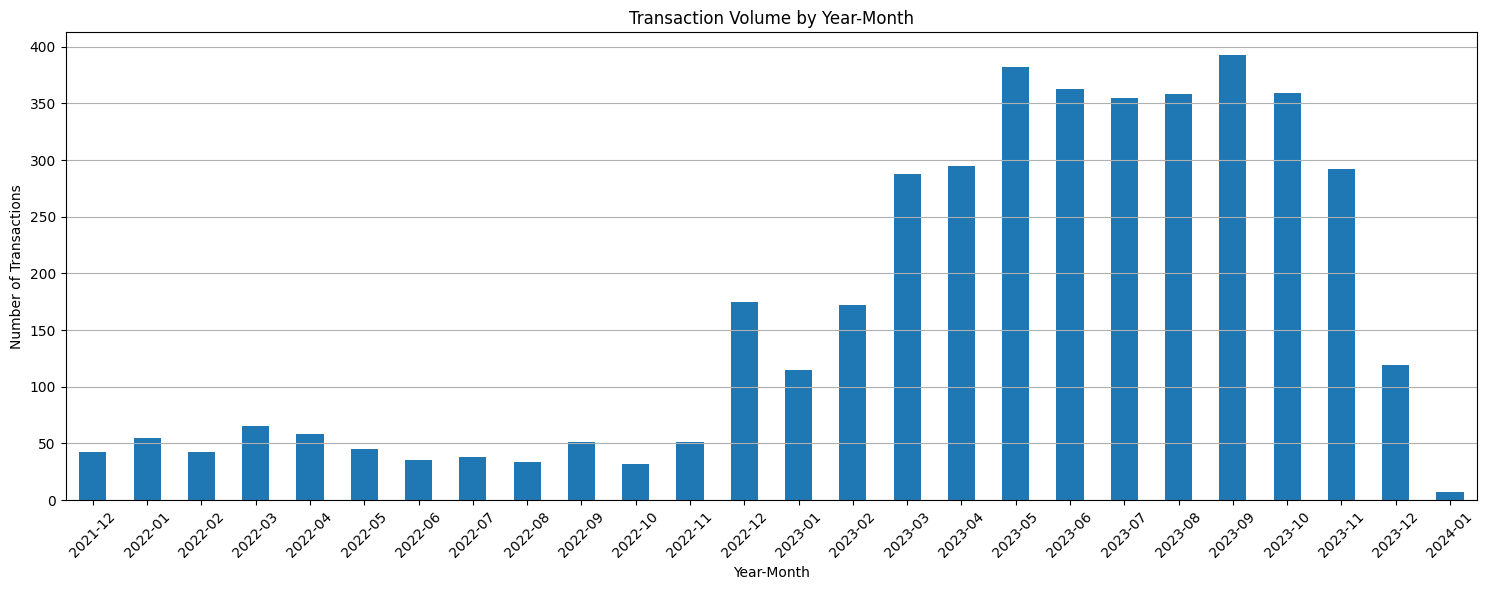

In [7]:
# Group by year-month and count transactions
filtered_data['year_month'] = filtered_data['transaction_date'].dt.to_period('M')
transaction_counts = filtered_data.groupby('year_month').size()

# Plotting the histogram
plt.figure(figsize=(15, 6))
transaction_counts.plot(kind='bar')
plt.title('Transaction Volume by Year-Month')
plt.xlabel('Year-Month')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

## Building Age Distribution Histogram
A histogram is created to visualize the distribution of building ages at the time of each transaction.

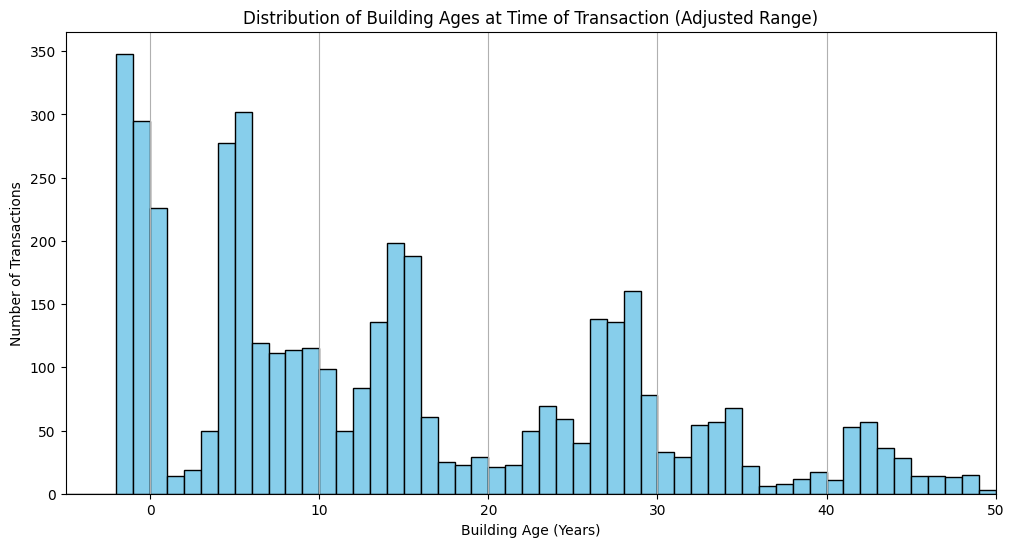

In [8]:
# Filtering out None values before plotting
valid_building_ages = filtered_data['building_age'].dropna()

# Plotting the histogram
plt.figure(figsize=(12, 6))
valid_building_ages.hist(bins=range(-5, 51), edgecolor='black', color='skyblue')
plt.title('Distribution of Building Ages at Time of Transaction (Adjusted Range)')
plt.xlabel('Building Age (Years)')
plt.ylabel('Number of Transactions')
plt.xlim(-5, 50)
plt.grid(axis='y')
plt.show()

## Average Price per 坪 Over Time
A line graph is plotted to show the average price per 坪 over time, focusing on data from January 2020 onwards.

/var/folders/qg/t_r78j517zv8dqw51p1cj9100000gn/T/ipykernel_32105/153577212.py:15: UserWarning: Glyph 33836 (\N{CJK UNIFIED IDEOGRAPH-842C}) missing from current font.
  plt.tight_layout()
/var/folders/qg/t_r78j517zv8dqw51p1cj9100000gn/T/ipykernel_32105/153577212.py:15: UserWarning: Glyph 20803 (\N{CJK UNIFIED IDEOGRAPH-5143}) missing from current font.
  plt.tight_layout()
/var/folders/qg/t_r78j517zv8dqw51p1cj9100000gn/T/ipykernel_32105/153577212.py:15: UserWarning: Glyph 22378 (\N{CJK UNIFIED IDEOGRAPH-576A}) missing from current font.
  plt.tight_layout()
/Users/pwang/Code-Playground/real-estate-analysis/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 33836 (\N{CJK UNIFIED IDEOGRAPH-842C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/pwang/Code-Playground/real-estate-analysis/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20803 (\N{CJK UNIFIED IDEOGRAPH-5143}) missing from curr

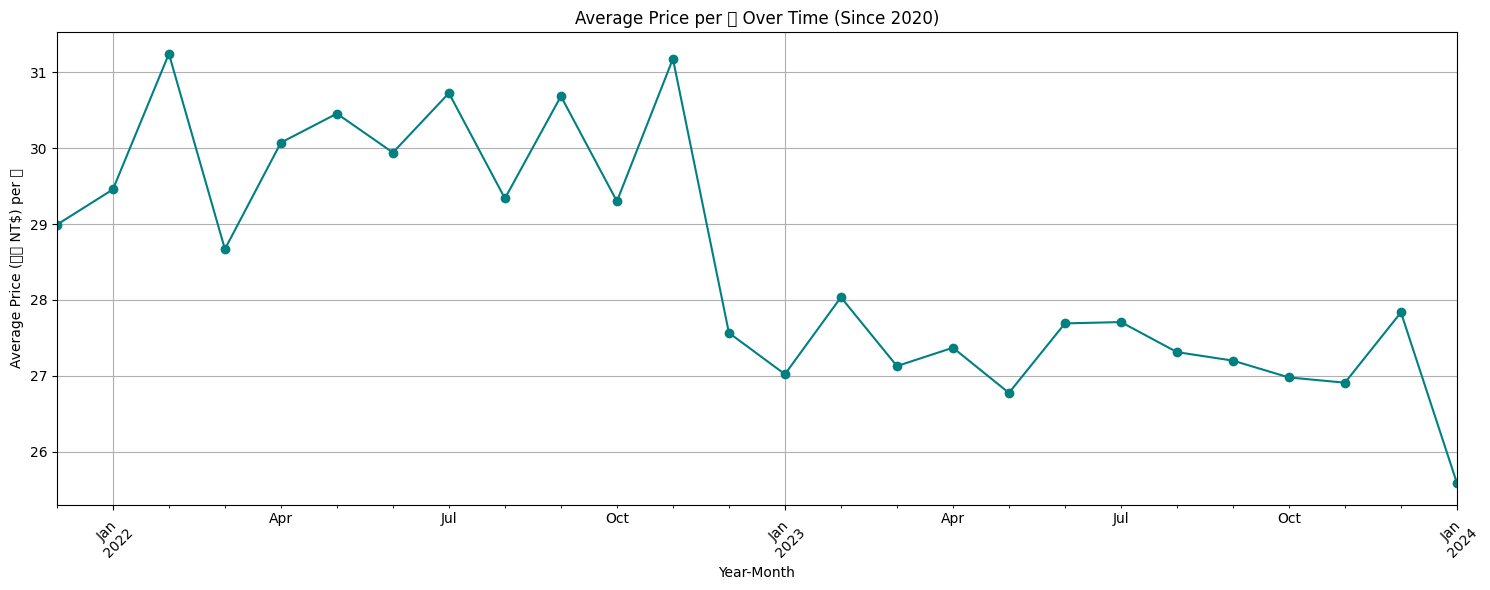

In [9]:
# Filtering data to include only transactions from January 2020 onwards
filtered_data_since_2020 = filtered_data[filtered_data['transaction_date'] >= pd.Timestamp(2020, 1, 1)]

# Group by year-month and calculate the average price per 坪 since 2020
average_price_per_ping_since_2020 = filtered_data_since_2020.groupby('year_month')['price_per_ping_10k'].mean()

# Plotting the average price per 坪 over time since 2020
plt.figure(figsize=(15, 6))
average_price_per_ping_since_2020.plot(kind='line', marker='o', color='teal')
plt.title('Average Price per 坪 Over Time (Since 2020)')
plt.xlabel('Year-Month')
plt.ylabel('Average Price (萬元 NT$) per 坪')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

### Parsing and Categorizing Floor Data

In this part of the analysis, we focus on parsing and processing the floor data. Our goal is to convert the floor numbers recorded in Traditional Chinese characters (`rps09`) into integers and compare them with the total number of floors in the building (`rps10`) to determine whether the traded property is situated on a high or low floor.

#### Converting Transaction Floor Numbers
First, we extract the floor information from the `rps09` column. This information is represented in Traditional Chinese characters, such as "十二層" (twelfth floor). We will remove the last character, "層", from each record and convert the remaining Traditional Chinese numerals into corresponding integers. Special attention is needed for certain cases, such as floors labeled as "basement", and for converting standalone characters like "十" into their numerical equivalents.

In [10]:

# Function to convert Chinese floor numbers to integers
def chinese_number_to_int(chinese_number):
    chinese_numerals = {'一': 1, '二': 2, '三': 3, '四': 4, '五': 5, '六': 6, '七': 7, '八': 8, '九': 9, '十': 10}
    if chinese_number in chinese_numerals:
        return chinese_numerals[chinese_number]
    elif chinese_number.startswith('十'):
        return 10 + chinese_numerals.get(chinese_number[1], 0)
    elif chinese_number.endswith('十'):
        return chinese_numerals[chinese_number[0]] * 10
    else:
        return chinese_numerals[chinese_number[0]] * 10 + chinese_numerals[chinese_number[1]]


# Adjusting the function to handle special cases like '地下' and '全'
def chinese_floor_to_int(floor):
    
    if not isinstance(floor, str):
        return None
    if '層' not in floor:
        return None
    floor_chainese_number_part = floor.split('層', 1)[0]
    
    try:
        # Handle special cases
        if floor_chainese_number_part.startswith('地下'):
            return -chinese_number_to_int(floor_chainese_number_part[2:])
        elif floor_chainese_number_part == '全':
            return 0  # '全' might represent a special case, assigning it as 0
        else :
            return chinese_number_to_int(floor_chainese_number_part)
    except:
        return 0


# Applying the conversion to the transaction floor
filtered_data['transaction_floor'] = filtered_data['rps09'].apply(chinese_floor_to_int)

# Converting total floors to integers
try:
    filtered_data['total_floors'] = filtered_data['rps10'].astype(int)
except:
    filtered_data['total_floors'] = filtered_data['rps10'].apply(chinese_floor_to_int)



# Classifying as high floor or low floor
filtered_data['floor_category'] = filtered_data.apply(lambda row: 'High Floor' if row['transaction_floor'] > (row['total_floors'] / 2) else 'Low Floor', axis=1)

#### Classifying Floors
After converting the floor data into integers, we will compare the transaction floor (`rps09`) with the total number of floors in the building (`rps10`). Based on this comparison, each transaction will be categorized as either "High Floor" or "Low Floor". Specifically, if the transaction floor is higher than half of the total number of floors, it will be categorized as a high floor; otherwise, it will be categorized as a low floor.

Implementing these steps will provide us with deeper insights, helping us understand the impact of floor location in real estate transactions. This is particularly important for analyzing market trends and formulating real estate strategies.

/var/folders/qg/t_r78j517zv8dqw51p1cj9100000gn/T/ipykernel_32105/1830434384.py:20: UserWarning: Glyph 33836 (\N{CJK UNIFIED IDEOGRAPH-842C}) missing from current font.
  plt.tight_layout()
/var/folders/qg/t_r78j517zv8dqw51p1cj9100000gn/T/ipykernel_32105/1830434384.py:20: UserWarning: Glyph 20803 (\N{CJK UNIFIED IDEOGRAPH-5143}) missing from current font.
  plt.tight_layout()
/var/folders/qg/t_r78j517zv8dqw51p1cj9100000gn/T/ipykernel_32105/1830434384.py:20: UserWarning: Glyph 22378 (\N{CJK UNIFIED IDEOGRAPH-576A}) missing from current font.
  plt.tight_layout()
/Users/pwang/Code-Playground/real-estate-analysis/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 33836 (\N{CJK UNIFIED IDEOGRAPH-842C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/pwang/Code-Playground/real-estate-analysis/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20803 (\N{CJK UNIFIED IDEOGRAPH-5143}) missing from c

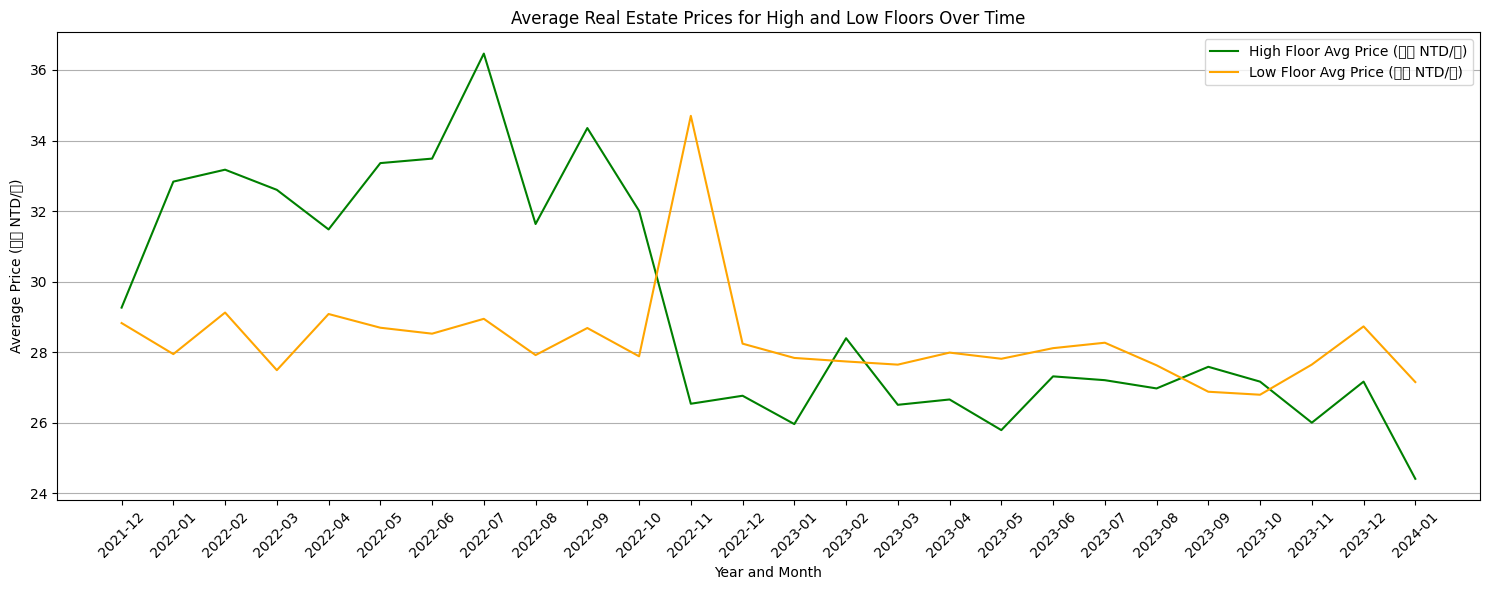

In [11]:

# Calculating the average price for high floor and low floor
avg_price_high_floor = filtered_data[filtered_data['floor_category'] == 'High Floor'].groupby('year_month')['price_per_ping_10k'].mean()
avg_price_low_floor = filtered_data[filtered_data['floor_category'] == 'Low Floor'].groupby('year_month')['price_per_ping_10k'].mean()

# Plotting
fig, ax = plt.subplots(figsize=(15, 6))

# Plotting high floor average prices
ax.plot(avg_price_high_floor.index.astype(str), avg_price_high_floor, color='green', label='High Floor Avg Price (萬元 NTD/坪)')

# Plotting low floor average prices
ax.plot(avg_price_low_floor.index.astype(str), avg_price_low_floor, color='orange', label='Low Floor Avg Price (萬元 NTD/坪)')

ax.set_title('Average Real Estate Prices for High and Low Floors Over Time')
ax.set_xlabel('Year and Month')
ax.set_ylabel('Average Price (萬元 NTD/坪)')
ax.legend()
ax.grid(axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Analysis of Real Estate Prices by Floor Category

This section of the analysis is dedicated to exploring the real estate prices with respect to the categorization of floors within the properties. A unique aspect of this dataset is the inclusion of transactions on specific floors that are traditionally considered either auspicious or inauspicious, like the 4th and 8th floors. 

#### Categorization by Floor Level
The dataset includes a variety of floor levels, and we have categorized these into four distinct groups for our analysis:
- High Floor: Transactions for properties located above the midpoint of the building's total floor count.
- Low Floor: Transactions for properties located below the midpoint of the building's total floor count.
- 4th Floor: Specifically, transactions that occur on the 4th floor, which in some cultures is considered unlucky.
- 8th Floor: Transactions that occur on the 8th floor, which is often seen as a very auspicious level due to its phonetic similarity to the word for "wealth" or "prosper" in Chinese.

#### Price Analysis
We calculate the average price per Ping for each floor category to see if there are notable price differences influenced by floor level. This is particularly interesting for the 4th and 8th floors due to the cultural significance attached to these numbers.

#### Visualization
The resulting plot features a dual-axis chart:
- The primary axis (left) represents the number of transactions over time, displayed as bars.
- The secondary axis (right) shows the average price per Ping for each floor category, displayed as lines of different colors for clear distinction.

Through this visualization, we aim to uncover any trends or patterns related to floor levels and their impact on real estate prices over time. This can offer valuable insights for buyers and sellers in the market, as well as investors looking to understand the nuances of the real estate market in the Tamsui District.

/var/folders/qg/t_r78j517zv8dqw51p1cj9100000gn/T/ipykernel_32105/1912058104.py:33: UserWarning: Glyph 33836 (\N{CJK UNIFIED IDEOGRAPH-842C}) missing from current font.
  plt.tight_layout()
/var/folders/qg/t_r78j517zv8dqw51p1cj9100000gn/T/ipykernel_32105/1912058104.py:33: UserWarning: Glyph 20803 (\N{CJK UNIFIED IDEOGRAPH-5143}) missing from current font.
  plt.tight_layout()
/var/folders/qg/t_r78j517zv8dqw51p1cj9100000gn/T/ipykernel_32105/1912058104.py:33: UserWarning: Glyph 22378 (\N{CJK UNIFIED IDEOGRAPH-576A}) missing from current font.
  plt.tight_layout()
/Users/pwang/Code-Playground/real-estate-analysis/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 33836 (\N{CJK UNIFIED IDEOGRAPH-842C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/pwang/Code-Playground/real-estate-analysis/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20803 (\N{CJK UNIFIED IDEOGRAPH-5143}) missing from c

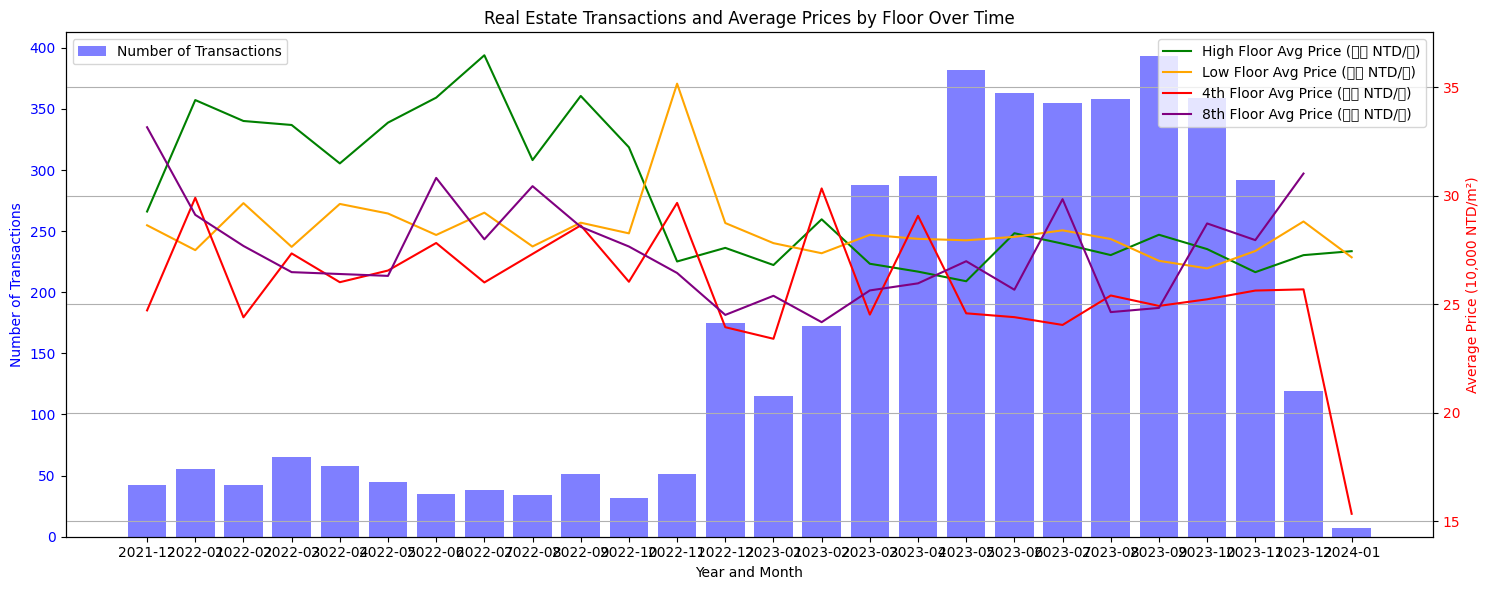

In [12]:

# Classifying as high floor, low floor, 4th floor, and 8th floor
filtered_data['floor_category'] = filtered_data.apply(lambda row: '4th Floor' if row['transaction_floor'] == 4 else ('8th Floor' if row['transaction_floor'] == 8 else ('High Floor' if row['transaction_floor'] > (row['total_floors'] / 2) else 'Low Floor')), axis=1)

# Calculating the average price for each floor category
avg_price_high_floor = filtered_data[filtered_data['floor_category'] == 'High Floor'].groupby('year_month')['price_per_ping_10k'].mean()
avg_price_low_floor = filtered_data[filtered_data['floor_category'] == 'Low Floor'].groupby('year_month')['price_per_ping_10k'].mean()
avg_price_4th_floor = filtered_data[filtered_data['floor_category'] == '4th Floor'].groupby('year_month')['price_per_ping_10k'].mean()
avg_price_8th_floor = filtered_data[filtered_data['floor_category'] == '8th Floor'].groupby('year_month')['price_per_ping_10k'].mean()

# Plotting
fig, ax1 = plt.subplots(figsize=(15, 6))

# Plotting the number of transactions
ax1.bar(transaction_counts.index.astype(str), transaction_counts, color='b', alpha=0.5, label='Number of Transactions')
ax1.set_xlabel('Year and Month')
ax1.set_ylabel('Number of Transactions', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.legend(loc='upper left')

# Creating a secondary axis for the average price
ax2 = ax1.twinx()
ax2.plot(avg_price_high_floor.index.astype(str), avg_price_high_floor, color='green', label='High Floor Avg Price (萬元 NTD/坪)')
ax2.plot(avg_price_low_floor.index.astype(str), avg_price_low_floor, color='orange', label='Low Floor Avg Price (萬元 NTD/坪)')
ax2.plot(avg_price_4th_floor.index.astype(str), avg_price_4th_floor, color='red', label='4th Floor Avg Price (萬元 NTD/坪)')
ax2.plot(avg_price_8th_floor.index.astype(str), avg_price_8th_floor, color='purple', label='8th Floor Avg Price (萬元 NTD/坪)')
ax2.set_ylabel('Average Price (10,000 NTD/m²)', color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax2.legend(loc='upper right')

plt.title('Real Estate Transactions and Average Prices by Floor Over Time')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

### Average Area Ratios Visualization

In this section, we calculate and visualize the average ratios of different areas related to real estate transactions. This analysis is crucial to understand how the space in properties is typically distributed among various components.

#### Calculation of Average Ratios
We calculate the average ratios for each type of area in the real estate transactions, which includes:
- Main Building
- Auxiliary Building
- Balcony
- Parking
- Public Facility

These ratios are calculated as the mean of their respective values in the dataset.

#### Bar Chart Visualization
- A bar chart is used to visualize these average ratios.
- The chart clearly represents each area type along the x-axis and their average ratios on the y-axis.
- This visualization helps in comparing the relative sizes of different areas in the properties.

### Boxplot Visualization of Area Ratios

This part of the analysis involves creating boxplots for the same area ratios to understand their distribution.

#### Boxplot Features
- Boxplots are drawn for Main Building, Auxiliary Building, Balcony,

 Parking, and Public Facility ratios.
- Each boxplot provides a statistical summary of the distributions, including the median, quartiles, and potential outliers.
- This visualization is particularly useful for identifying the range and variance of each ratio, offering insights into how uniformly or diversely each area type is represented across the dataset.

### Additional Visualizations: Stacked Bar Chart, Boxplot, and Violin Plot

#### Stacked Bar Chart of Area Ratios
- A stacked bar chart is created using a sample of the data.
- This chart displays the composition of each transaction in terms of the different area ratios, offering a detailed view of each property's space allocation.
- The visualization is useful for analyzing multiple components within individual transactions.

#### Boxplot and Violin Plot of Area Ratios
- Additional boxplots and violin plots are generated for the main building, auxiliary building, balcony, and parking ratios.
- While the boxplot provides a statistical summary, the violin plot combines the boxplot with a kernel density estimation, showing the distribution's density at different values.
- These plots are instrumental in understanding the distribution of area ratios, highlighting areas with greater variance or skewness in the dataset.

These visualizations collectively offer a comprehensive view of how different areas within real estate properties are proportioned. The variety of charts - bar, boxplot, and violin plot - each contribute unique perspectives, aiding in a thorough understanding of the dataset's characteristics. The stacked bar chart, in particular, allows for an individualized transaction analysis, while the boxplot and violin plot offer more generalized, statistical insights into the overall data distribution.

/var/folders/qg/t_r78j517zv8dqw51p1cj9100000gn/T/ipykernel_32105/759031357.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Area Type', y='Average Ratio', data=average_ratios_df, palette='coolwarm')


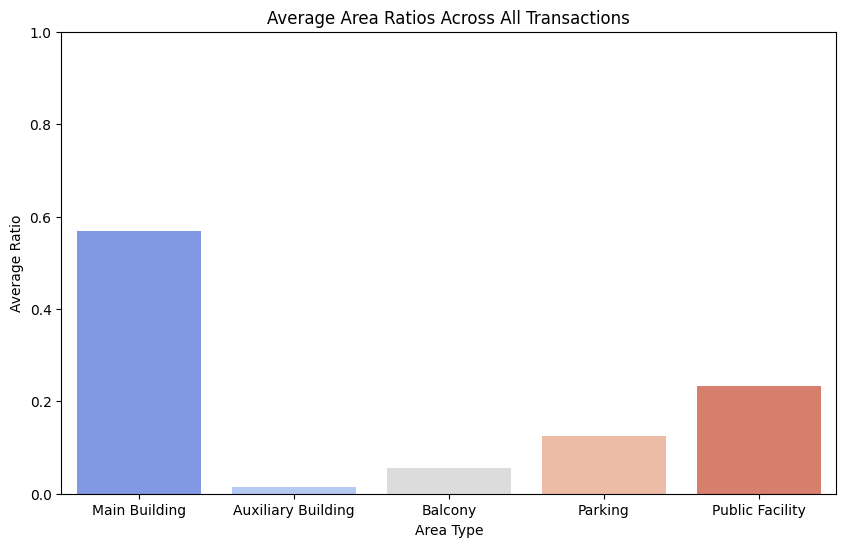

In [13]:
# Calculate the average ratios for each area type
average_ratios = {
    'Main Building': filtered_data['main_building_ratio'].mean(),
    'Auxiliary Building': filtered_data['auxiliary_building_ratio'].mean(),
    'Balcony': filtered_data['balcony_ratio'].mean(),
    'Parking': filtered_data['parking_ratio'].mean(),
    'Public Facility': filtered_data['public_facility_ratio'].mean()
}
average_ratios_df = pd.DataFrame(list(average_ratios.items()), columns=['Area Type', 'Average Ratio'])

# Plotting the average ratios using a bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='Area Type', y='Average Ratio', data=average_ratios_df, palette='coolwarm')
plt.title('Average Area Ratios Across All Transactions')
plt.xlabel('Area Type')
plt.ylabel('Average Ratio')
plt.ylim(0, 1)  # Ratios should fall between 0 and 1
plt.show()


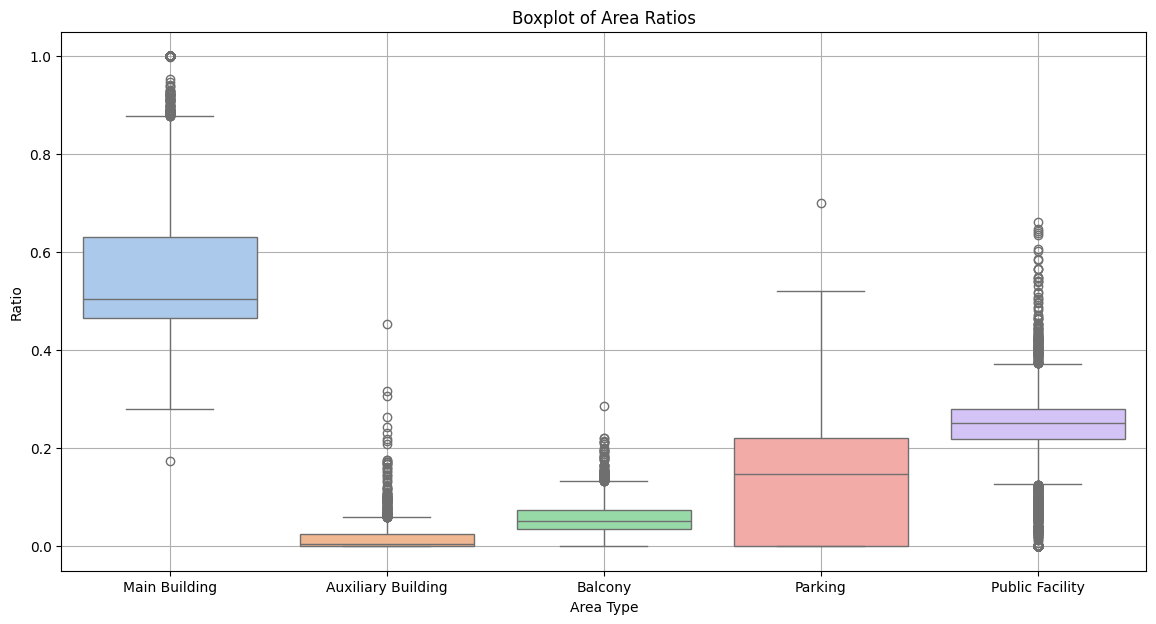

In [14]:
# Plotting the boxplots for each area type ratio on the same y-axis
plt.figure(figsize=(14, 7))
sns.boxplot(data=filtered_data[['main_building_ratio', 'auxiliary_building_ratio', 'balcony_ratio', 'parking_ratio', 'public_facility_ratio']], palette='pastel')
plt.title('Boxplot of Area Ratios')
plt.ylabel('Ratio')
plt.xlabel('Area Type')
plt.xticks([0, 1, 2, 3, 4], ['Main Building', 'Auxiliary Building', 'Balcony', 'Parking', 'Public Facility'])
plt.grid(True)
plt.show()


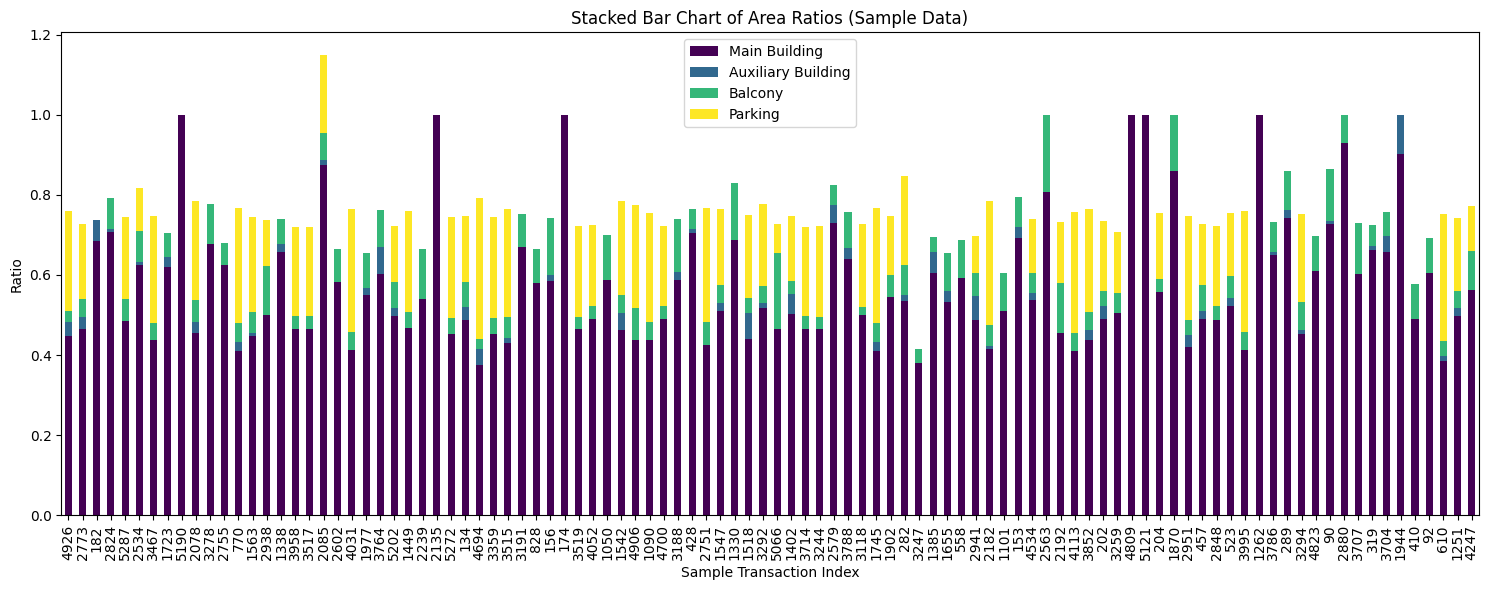

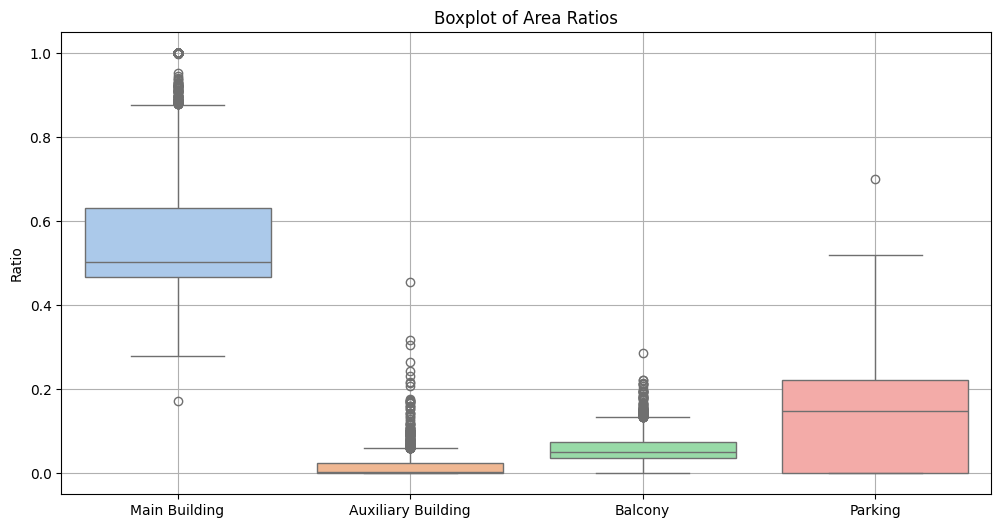

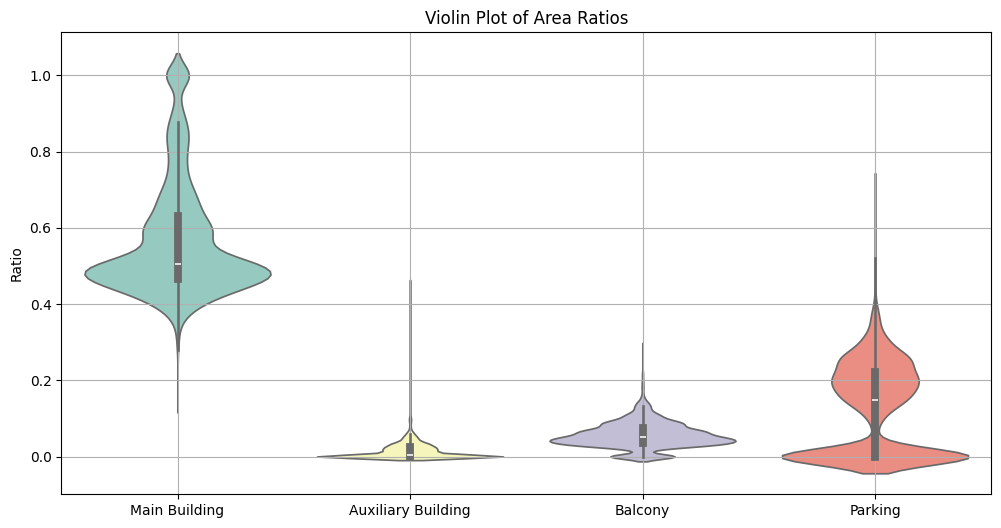

In [15]:

sample_size = min(100, len(filtered_data))  # 選取樣本大小
sample_data = filtered_data.sample(sample_size)

stacked_bar_plot = sample_data[['main_building_ratio', 'auxiliary_building_ratio', 'balcony_ratio', 'parking_ratio']]
stacked_bar_plot.plot(kind='bar', stacked=True, figsize=(15, 6), colormap='viridis')
plt.title('Stacked Bar Chart of Area Ratios (Sample Data)')
plt.xlabel('Sample Transaction Index')
plt.ylabel('Ratio')
plt.legend(['Main Building', 'Auxiliary Building', 'Balcony', 'Parking'])
plt.tight_layout()
plt.show()

# 繪製箱形圖
plt.figure(figsize=(12, 6))
sns.boxplot(data=filtered_data[['main_building_ratio', 'auxiliary_building_ratio', 'balcony_ratio', 'parking_ratio']], palette='pastel')
plt.title('Boxplot of Area Ratios')
plt.ylabel('Ratio')
plt.xticks([0, 1, 2, 3], ['Main Building', 'Auxiliary Building', 'Balcony', 'Parking'])
plt.grid(True)
plt.show()

# 繪製小提琴圖
plt.figure(figsize=(12, 6))
sns.violinplot(data=filtered_data[['main_building_ratio', 'auxiliary_building_ratio', 'balcony_ratio', 'parking_ratio']], palette='Set3')
plt.title('Violin Plot of Area Ratios')
plt.ylabel('Ratio')
plt.xticks([0, 1, 2, 3], ['Main Building', 'Auxiliary Building', 'Balcony', 'Parking'])
plt.grid(True)
plt.show()

### Analyzing the Impact of Property Layout on Price per Ping

In this segment of our analysis, we delve into the influence of property layout on the pricing per Ping. The term "layout" refers to the configuration of rooms within a property, which is a significant factor in real estate valuation. 

#### Layout Configuration
The `layout_description` field provides a detailed composition of each property, signifying the number of rooms, halls (living/dining areas), and bathrooms. These are denoted by the following abbreviations in the dataset:
- '房' (room)
- '廳' (hall)
- '衛' (bathroom)

For instance, a "3房2廳2衛" layout describes a property with 3 rooms, 2 halls, and 2 bathrooms.

#### Calculation of Area in Ping
We convert the total area from square meters to Ping, a traditional Taiwanese unit of area, where 1 Ping is equal to 3.3058 square meters. This standard measurement allows for a consistent comparison across various properties and layouts.

#### Price Analysis by Layout
We compute the average price per Ping for each unique layout configuration, which provides insight into the market value attributed to different types of property layouts. This measure is crucial for understanding how the spatial arrangement within a property affects its price, reflecting buyer preferences and market trends.

#### Results Presentation
The average price per Ping is then sorted and displayed for each layout configuration. This sorted list offers a clear view of which property layouts command higher prices in the real estate market and will enable us to identify any patterns or preferences in property selection among buyers in the Tamsui District.

In [16]:

## Calculating the total area in Ping (1 Ping = 3.3058 square meters)
#filtered_data['total_area_ping'] = filtered_data['rps15'] / 3.3058

age_limit = 10 

## 分類為老屋或新屋
filtered_data['age_category'] = filtered_data['building_age'].apply(lambda x: 'Old' if x >= age_limit else 'New')

## Creating a new column for layout description
#filtered_data['layout_description'] = filtered_data['rps16'].astype(str) + '房' + filtered_data['rps17'].astype(str) + '廳' + filtered_data['rps18'].astype(str) + '衛'
#filtered_data['total_area_ping_per_10000'] = filtered_data['total_area_ping'] / 10000
#layout_avg_price = filtered_data.groupby('layout_description')['total_area_ping'].mean().sort_values()

## Displaying the average price per Ping for each layout
#layout_avg_price

# 確保至少已計算好 price_per_ping_10k 或 price_per_ping
# 比如上段你已有 filtered_data['price_per_ping_10k']

# 建立 layout_description 欄位（無誤）
filtered_data['layout_description'] = (
    filtered_data['rps16'].astype(str) + '房' +
    filtered_data['rps17'].astype(str) + '廳' +
    filtered_data['rps18'].astype(str) + '衛'
)

# 依 layout 計算平均「每坪單價（萬元／坪）」
layout_avg_price = (
    filtered_data
    .groupby('layout_description')['price_per_ping_10k']
    .mean()
    .sort_values(ascending=False)
)

# 顯示結果
print("Average Price per 坪 by Layout (萬元／坪):")
print(layout_avg_price)

Average Price per 坪 by Layout (萬元／坪):
layout_description
4房1廳4衛       49.111403
10房4廳13衛     47.273387
6房4廳5衛       44.637684
3房4廳3衛       43.124461
0房2廳2衛       43.117023
               ...    
10房0廳8衛      13.728264
10房10廳10衛    12.822809
0房8廳8衛       10.389752
6房4廳6衛        7.577851
6房4廳4衛        7.300165
Name: price_per_ping_10k, Length: 103, dtype: float64


### Statistical Price Analysis of Selected Property Layouts

This section of the analysis targets a more statistical approach to examining the prices of selected property layouts within our dataset. We focus on a subset of property configurations to ascertain their market valuation and variability.

#### Selection of Property Layouts
We have preselected a range of popular property layouts to include in our analysis, denoted by the number of rooms, halls, and bathrooms they contain. The layouts considered are:
- '2房1廳1衛' (2 rooms, 1 hall, 1 bathroom)
- '2房2廳1衛' (2 rooms, 2 halls, 1 bathroom)
- '3房2廳1衛' (3 rooms, 2 halls, 1 bathroom)
- '3房2廳2衛' (3 rooms, 2 halls, 2 bathrooms)

These layouts represent a cross-section of the market that is diverse yet sufficiently common to provide a reliable insight into pricing trends.

#### Calculation of Statistical Measures
For each of the selected layouts, we compute several key statistical measures to understand their price distribution:
- Count: The number of transactions for each layout, giving an indication of its popularity or availability in the market.
- Mean: The average price per Ping, offering a baseline for comparison.
- Quantile (20th percentile): This measure provides insight into the lower end of the price distribution, helping to identify what a buyer might expect to pay at a more accessible price point.
- Median: The middle value of the price range, which can be more robust to outliers than the mean.
- Standard Deviation: A measure of price variability, indicating the spread or dispersion of prices around the mean.

#### Visualization and Interpretation
The calculated statistics are then presented, revealing the pricing dynamics and variability for each layout. This information is crucial for buyers, sellers, and analysts as it not only reflects the current market conditions but also helps in predicting future trends and in making informed decisions. Through this analysis, we aim to uncover patterns that can guide potential investment strategies and property development.

In [17]:
# Select the specified layouts
selected_layouts = ['2房1廳1衛', '2房2廳1衛', '3房2廳1衛', '3房2廳2衛']
selected_layouts_data = (
    filtered_data[filtered_data['layout_description'].isin(selected_layouts)]
    .copy()
)

# Compute statistics on 'price_per_ping_10k' (10,000 NTD per ping)
layout_stats = (
    selected_layouts_data
    .groupby('layout_description')['price_per_ping_10k']
    .agg(
        transaction_count='count',
        mean_price='mean',
        p20=lambda x: x.quantile(0.2),
        median_price='median',
        price_std='std'
    )
    .rename(columns={
        'transaction_count': 'Transaction Count',
        'mean_price': 'Mean Price (10k NTD/坪)',
        'p20': '20th Percentile (10k NTD/坪)',
        'median_price': 'Median Price (10k NTD/坪)',
        'price_std': 'Price Std Dev (10k NTD/坪)'
    })
)

# Display the statistics
print(layout_stats)

                    Transaction Count  Mean Price (10k NTD/坪)  \
layout_description                                              
2房1廳1衛                            318               27.722667   
2房2廳1衛                            679               27.781815   
3房2廳1衛                             96               23.654483   
3房2廳2衛                           1341               27.137135   

                    20th Percentile (10k NTD/坪)  Median Price (10k NTD/坪)  \
layout_description                                                          
2房1廳1衛                                22.057454                 27.053553   
2房2廳1衛                                23.055470                 27.215206   
3房2廳1衛                                15.169256                 22.821321   
3房2廳2衛                                22.641652                 26.718346   

                    Price Std Dev (10k NTD/坪)  
layout_description                             
2房1廳1衛                               7.108228  
2房

### Visualizing Price Variability Across Different Property Layouts

The provided Python code block is set up to visualize the distribution of property prices for a selection of layouts using a boxplot. This visual representation allows us to observe not just the central tendencies like the median and mean, but also the variability and presence of outliers in the pricing data.

#### English Translation of Layout Descriptions
The layout descriptions, originally in Traditional Chinese, have been translated into English abbreviations for ease of understanding and visualization. The translations follow these conventions:
- '房' (room) to 'R'
- '廳' (hall) to 'D'
- '衛' (bathroom) to 'B'

This translation facilitates a clearer interpretation of the plots for an international audience and makes the data more accessible.

#### Selection Criteria for Layouts
We focus on four specific layout types, which are common in the Tamsui District's real estate market:
- '2R1D1B': 2 Rooms, 1 Hall, 1 Bathroom
- '2R2D1B': 2 Rooms, 2 Halls, 1 Bathroom
- '3R2D1B': 3 Rooms, 2 Halls, 1 Bathroom
- '3R2D2B': 3 Rooms, 2 Halls, 2 Bathrooms

#### Color Palette Choice
A pastel color palette is chosen to create the boxplots, offering a visually soothing and aesthetically pleasing look. The pastel colors are soft enough to not overpower the visual senses but are distinct enough to differentiate between the layout categories clearly.

#### Boxplot Creation and Display
Using seaborn's `boxplot` function, we plot the data for each layout type, allowing us to compare the price ranges and distributions across the different layouts. The use of the pastel palette ensures that each category is easily identifiable, with the boxplot providing insights into the spread and skewness of prices within each category.

The resulting plot includes the following elements:
- The central box represents the interquartile range (IQR) of the dataset.
- The line within the box shows the median price.
- The 'whiskers' extend to show the range of the data within 1.5 IQRs from the quartiles, excluding outliers.
- Outliers are plotted as individual points beyond the whiskers.

This visualization aids in understanding how layout configurations impact property prices, highlighting the variability and potential factors influencing buyer decisions. It is a valuable tool for stakeholders in the real estate market, including buyers, sellers, developers, and investors, providing them with actionable insights into property value trends.

/var/folders/qg/t_r78j517zv8dqw51p1cj9100000gn/T/ipykernel_32105/3406555642.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/qg/t_r78j517zv8dqw51p1cj9100000gn/T/ipykernel_32105/3406555642.py:27: UserWarning: Glyph 22378 (\N{CJK UNIFIED IDEOGRAPH-576A}) missing from current font.
  plt.tight_layout()
/Users/pwang/Code-Playground/real-estate-analysis/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 22378 (\N{CJK UNIFIED IDEOGRAPH-576A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


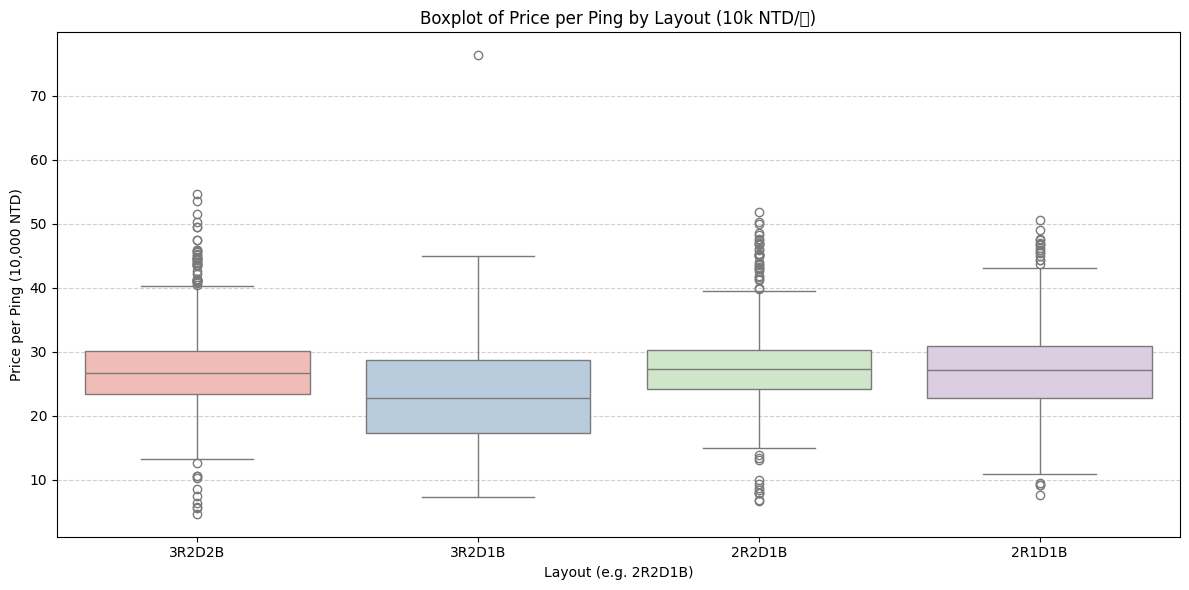

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# 建立英文格局欄位
selected_layouts_data['layout_description_eng'] = (
    selected_layouts_data['layout_description']
    .str.replace('房', 'R').str.replace('廳', 'D').str.replace('衛', 'B')
)

# 選定格局
df_eng = selected_layouts_data[
    selected_layouts_data['layout_description_eng'].isin(['2R1D1B','2R2D1B','3R2D1B','3R2D2B'])
].copy()

# Boxplot（每坪單價）
plt.figure(figsize=(12, 6))
sns.boxplot(
    x='layout_description_eng',
    y='price_per_ping_10k',
    data=df_eng,
    palette=["#FBB4AE","#B3CDE3","#CCEBC5","#DECBE4"]
)
plt.title('Boxplot of Price per Ping by Layout (10k NTD/坪)')
plt.xlabel('Layout (e.g. 2R2D1B)')
plt.ylabel('Price per Ping (10,000 NTD)')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### Floor-Level Price Analysis for Selected Property Layouts

This section of the notebook illustrates how the floor level may influence the price per Ping for properties within selected layouts. We use boxplots to compare the price distributions between properties on high floors versus low floors.

#### Selection of Layouts and Floor Categories
For a focused analysis, we've narrowed down our examination to two specific layouts:
- '3R2D2B': 3 Rooms, 2 Halls, 2 Bathrooms
- '2R2D1B': 2 Rooms, 2 Halls, 1 Bathroom

These layouts are further categorized by their floor levels, allowing us to distinguish between 'High Floor' and 'Low Floor' properties, providing insights into the vertical dimension's impact on pricing.

#### Custom Color Palette
To visually represent the two categories of floor levels, we define a custom color palette:
- Grass Green (`#229176`): Representing the 'High Floor' category, this color symbolizes an elevated position and possibly a premium in price or desirability.
- Deep Green (`#005711`): Used for the 'Low Floor' category, suggesting a more grounded or traditional value perception.

#### Boxplot Visualization
The seaborn boxplot function is employed to create a comparison between the selected layouts. Each boxplot is color-coded to reflect its floor category, enabling an immediate visual interpretation of how floor levels might correlate with the property prices.

The boxplot diagram includes:
- Central boxes indicating the interquartile range of prices for each category.
- Median prices represented by a line within the box.
- Whiskers extending to show the full range of the data, giving a sense of price volatility.
- Outliers indicated as individual points, which could represent unique value propositions or market anomalies.

#### Interpretation
By plotting the boxplots for these categories side by side, we can discern any noticeable differences in the price ranges and distributions between different floors. Such insights can be instrumental for stakeholders, including developers who design floor plans, realtors who market these properties, and buyers who might prioritize certain floor levels based on price and personal preference. This analysis thus contributes to a more nuanced understanding of the Tamsui District's real estate market.

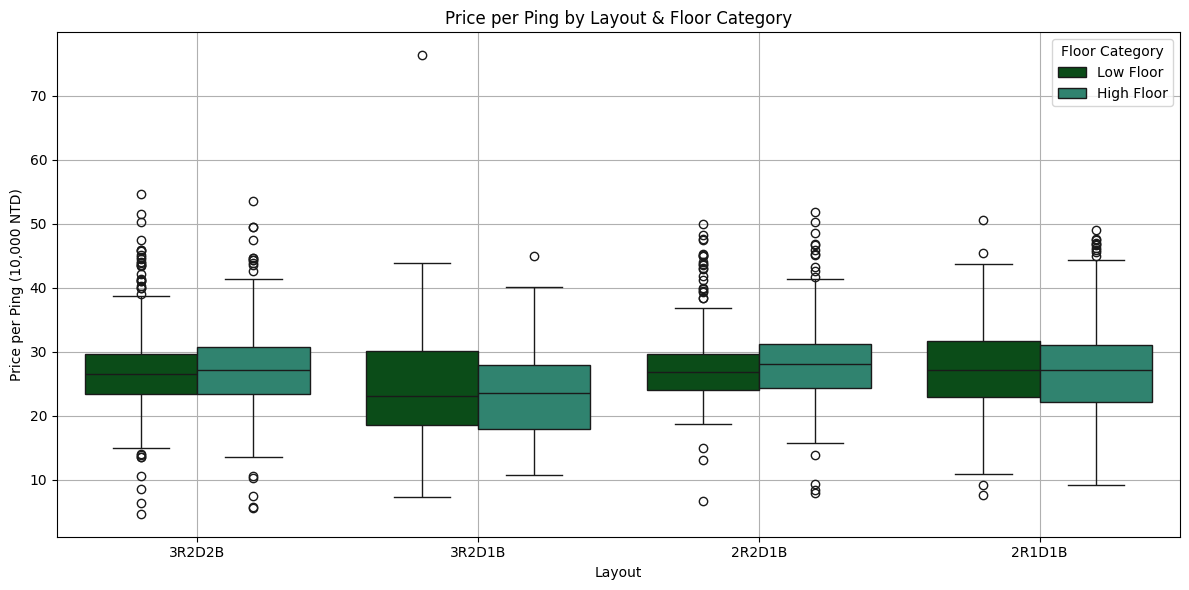

In [19]:
# Filtering data for the specified layouts again with floor category
df_floor = df_eng[df_eng['floor_category'].isin(['High Floor','Low Floor'])].copy()

plt.figure(figsize=(12,6))
sns.boxplot(
    x='layout_description_eng',
    y='price_per_ping_10k',
    hue='floor_category',
    data=df_floor,
    palette={"High Floor":"#229176","Low Floor":"#005711"}
)
plt.title('Price per Ping by Layout & Floor Category')
plt.xlabel('Layout')
plt.ylabel('Price per Ping (10,000 NTD)')
plt.grid(True)
plt.legend(title='Floor Category')
plt.tight_layout()
plt.show()

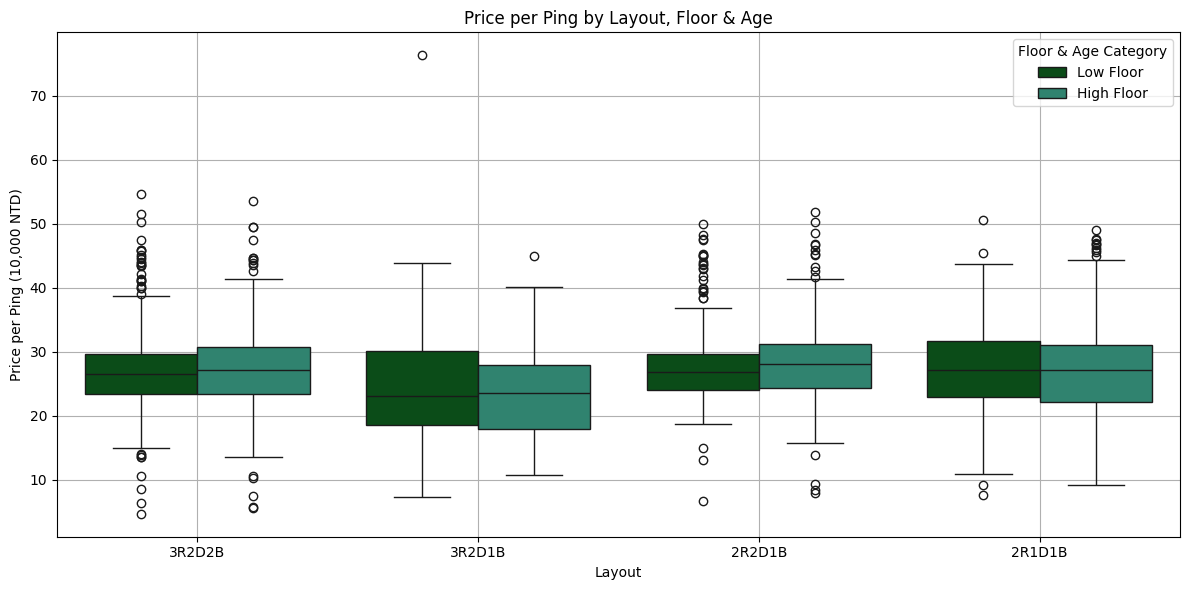

In [20]:
# 篩選加入 age_category 的資料
df_floor_age = df_floor[df_floor['age_category'].isin(['Old','New'])].copy()

plt.figure(figsize=(12,6))
sns.boxplot(
    x='layout_description_eng',
    y='price_per_ping_10k',
    hue='floor_category',
    data=df_floor_age,
    palette={"High Floor":"#229176","Low Floor":"#005711"}
)
plt.title('Price per Ping by Layout, Floor & Age')
plt.xlabel('Layout')
plt.ylabel('Price per Ping (10,000 NTD)')
plt.grid(True)
plt.legend(title='Floor & Age Category')
plt.tight_layout()
plt.show()
